In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('talk')
sns.set_style("whitegrid")

# Linear Time-invariant Filters

*Linear filters* process time-varying input signals to produce output signals, subject to the constraint of *linearity*.
In most cases these linear filters are also time *invariant* (or *shift invariant*) in which case they can be analyzed exactly using [LTI](def-linear-time-invariant) ('linear time-invariant') system theory.

```{admonition} Linear Time-invariant Filters (LTI)
:name: def-linear-time-invariant
:class: definition

Let $x(t)$ be the input signal and $y(t)$ be the output signal of a filter.
Then a filter is *linear time-invariant* if the following two conditions hold:

1. Linearity: $a \cdot x(t)$ translates to $a \cdot y(t)$ and $x_1(t) + x_2(t)$ translate to $y_1(t) + y_2(t)$ (superposition principle).
2. Time-invariant: whether we apply an input to the filter now or some time later does not matter. The filters effect does not change over time.

```

For example, if we modulate the cutoff frequency of a filter, it is no longer *time-invariant*.
To analyse the behaviour of a *linear filter* one looks at two different effects.

1. **Frequency response** (frequency domain): how does the amplitude and phase of a frequency $f$ changes.
2. **Impulse response** (time domain):

## Frequency Response

The frequency response of a filter tells us how it effects a the amplitude and phase of a frequency of the input signal.
[LTI filters](def-linear-time-invariant) can be characterized in the frequency domain by the *Z transform*.
As a result of the properties of these transforms, the output of the system in the frequency domain is the product of the transfer function and the transform of the input.
In other words, convolution in the time domain is equivalent to multiplication in the frequency domain.

```{admonition} Frequency response
:name: def-frequency-response
:class: definition

The *frequency response* of a *linear filter* be represented in one formula (see section [Complex Numbers](sec-complex-numbers))

\begin{equation}
H(\omega) = \underbrace{G(\omega)}_{\text{Amplitude}} \cdot \underbrace{e^{i \mathcal{\Theta}(\omega)}}_{\text{Phase}}.
\end{equation}

where $G(\omega)$ is the *amplutide frequency response* and $\mathcal{\Theta}(\omega)$ the *phase response* of the filter.

```

The *gain* $G(f)$ in frequency $f$ is equal to the frequency amplitude of the input signal divided by the frequency amplitude of the output signal:

\begin{equation}
G(f) = \frac{O(f)}{I(f)}
\end{equation}

```{admonition} Gain of LTI Filters
:name: def-gain-lti-theorem
:class: theorem

If the input to any any [LTI filter](def-linear-time-invariant) is a complex waveform $A \cdot e^{i \omega t}$, the output will be some constant times the input $B \cdot e^{i\omega t}$ and 

$$G(\omega) = \frac{B}{A}.$$

```

The default *low-* ``LPF`` and *highpass filters* ``HPF`` ugens of ``sclang`` filter frequencies above or below some *cutoff frequency*.
They are *2nd order Butterworth low-/highpass filter*.

```{figure} ../../../figs/sounddesign/filters/butterworth-filter.png
---
width: 600px
name: fig-butterworth-filter
---
Frequency response of a first-order Butterworth lowpass filter. By Alejo2083 - Own work, CC BY-SA 3.0, [link](https://commons.wikimedia.org/w/index.php?curid=735081).
```

The *frequency response* of a *2nd order Butterworth lowpass filter* is illustrated above. 
The filter reduces the gain (amplitude) for frequencies above the cutoff frequency and shifts their phases.
Well, that is not entirely true because the cutoff frequency is also reduced by 6 [decibel (dB)](sec-intensity), so the reduction starts a little bit below the cutoff frequency.
Reducing the loudness by 6 dB means that the perceived level is reduced by a factor of 4.
The top plot of {numref}`Fig. {number} <fig-butterworth-filter>` shows the reduction in amplitude.

The second effect of the filter is a phase shift; compare the bottom plot of {numref}`Fig. {number} <fig-butterworth-filter>`.
This effect is crucial if we combine multiple filters because they interact!
In other words: we can not just combine a high pass and lowpass filter to get the same result as a band pass filter!

The following code is an example of a band pass filter.
First, we use a lowpass and high pass filter; then a band pass filter.
The results sound very similar but not identical.

```isc
({
    var sig = LFSaw.ar(500) ! 2 * 0.5;
    sig = HPF.ar(sig, 200);
    sig = LPF.ar(sig, 300);
    sig
}.play;)

({
    var sig = LFSaw.ar(500) ! 2 * 0.5;
    var bandwidth = 100;
    var cuttoffFeq = 200;
    sig = BPF.ar(sig, 250, rq: bandwidth / cuttoffFeq);
    sig
}.play;)
```

For completeness I also want to mention the inverse filter of a band pass filter: the band reject filter ``BRF``.
The following example rejects frequencies between 200 and 300 Hz, i.e., the inverse operation as before.

```isc
({
    var sig = LFSaw.ar(500) ! 2 * 0.5;
    var bandwidth = 100;
    var cuttoffFeq = 200;
    sig = BRF.ar(sig, 250, rq: bandwidth / cuttoffFeq);
    sig
}.play;)
```

(sec-analysis-simple-filter)=
## Analysis of a Simple Filter

Let $x[n]$ be an input signal, $y[n]$ the output signal of the filter and $f_s = \frac{1}{T}$ the sample rate.
Let use start with a very *simple filter*:

\begin{equation}
y[n] = x[n] + x[n-1], \quad n = 0, 1, 2, \ldots
\end{equation}

Note that $x[t]$ is defined for $t = n T$ with $n = 0, 1, 2, \ldots$
Our *simple filter* is a [linear and time-invariant](def-linear-time-invariant) filter.
The [OnePole](https://doc.sccode.org/Classes/OnePole.html) unit generator is a flexible version of this filter.

You might suspect that since is the simplest possible *lowpass filter*, it is also somehow the worst possible low-pass filter. 
How bad is it? 
In what sense is it bad? How do we even know it is a low-pass at all? 
The answers to these and related questions will become apparent when we find the [frequency response](def-frequency-response) of this filter.

Our goal is to use a test singal that consists of only one frequency and then reformulate $y[n]$ such that we arrive at

\begin{equation*}
x[n] = H(\omega) \cdot x[n].
\end{equation*}

where $H(\omega)$ has to be independent of $n$.

We start by using test signals, i.e., we define $x[n]$ to be a sinusoid containing **one** specific frequency $f$.
Therefore, we assume:

\begin{equation*}
x[n] = A \cdot e^{i(2\pi f n T + \phi)}.
\end{equation*}

```isc
// here we test for f = f_s / 5
(	
{
  var sig = SinOsc.ar(s.sampleRate/5);
  [sig, OneZero.ar(sig, coef: 0.5, mul: 2)]
}.plot(20/s.sampleRate)
)
```

Let us simplify by assuming $A = 1$, $\phi = 0$ and $\omega = 2\pi f$ thus

\begin{equation*}
x[n] = e^{i \omega n T}.
\end{equation*}

Therefore, $y[n]$ is defined by

\begin{equation*}
\begin{split}
y[n] &= e^{i \omega n T} + e^{i \omega (n-1) T}\\
&= e^{i \omega n T} + e^{i \omega n T} \cdot e^{-i \omega n T}\\
&= (1 + e^{-i \omega T}) \cdot e^{i \omega n T}\\
&= (1 + e^{-i \omega T}) \cdot x[n]\\
&= H(\omega) \cdot x[n]
\end{split}
\end{equation*}

Therefore, the *gain* for this filter is

$$G(\omega) = |(1 + e^{-i \omega T})|$$

and the phase response is

$$\mathcal{\Theta}(\omega) = \angle 1 + e^{-i \omega T}.$$

We can further manipulate the formula for the *gain* by the following:

\begin{equation*}
\begin{split}
1 + e^{-i \omega T} &= e^0 + e^{-i \omega T}\\
&= (e^{i\omega T / 2} + e^{-i \omega T / 2}) \cdot e^{-i \omega T / 2}
\end{split}
\end{equation*}

using 

$$\cos(\phi) = \frac{e^{i\phi} - e^{-i \phi} }{2}$$

we get

\begin{equation*}
\begin{split}
1 + e^{-i \omega T} &= 2 \cdot \cos(\omega T / 2) \cdot e^{-i \omega T / 2}
\end{split}
\end{equation*}

Thus

$$G(\omega) = |2 \cdot \cos(\omega T / 2) \cdot e^{-i \omega T / 2}| = 2|\cos(\omega T / 2)|.$$

Because of the [Nyquist–Shannon sampling theorem](theorem-sampling), we can assume that we only look at frequencies $f$ such that $-f_s/2 \leq f \leq +f_s / 2$ holds.
Therefore, the equation simplifies to

$$2\cos(\omega T / 2)$$

for $-\pi \leq \omega \leq \pi$.
The following plot shows the amplitude frequency response in $\omega$.

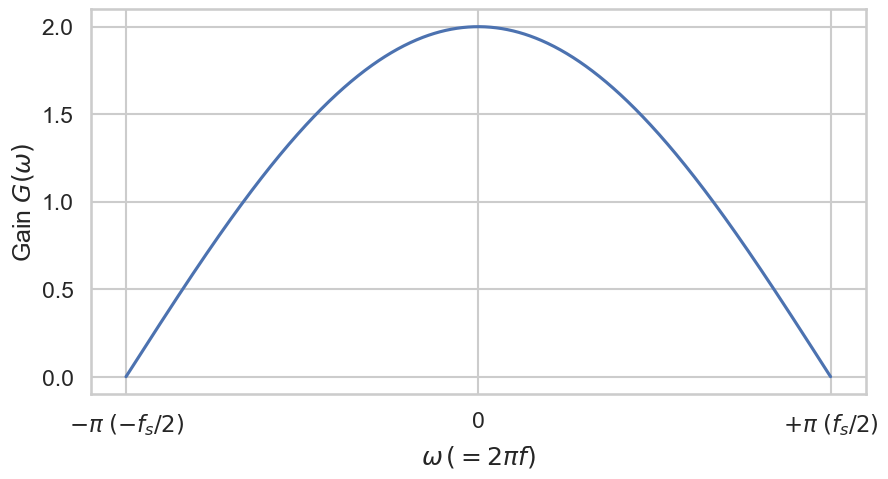

In [2]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x: 2 * np.cos(x/2)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, gain(t), label=r'$y(t)$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$ $(-f_s/2)$', r'0', r'$+\pi$ $(f_s/2)$'])
ax.set_ylabel(r'Gain $G(\omega)$')
ax.set_xlabel(r'$\omega\,(=2\pi f)$');

Secondly we look at the *phase response*

$$\mathcal{\Theta}(\omega) = -\frac{\omega T}{2}, \quad -\pi \leq \omega \leq \pi.$$

If we set $T = 1$ the plot looks like the following figure.

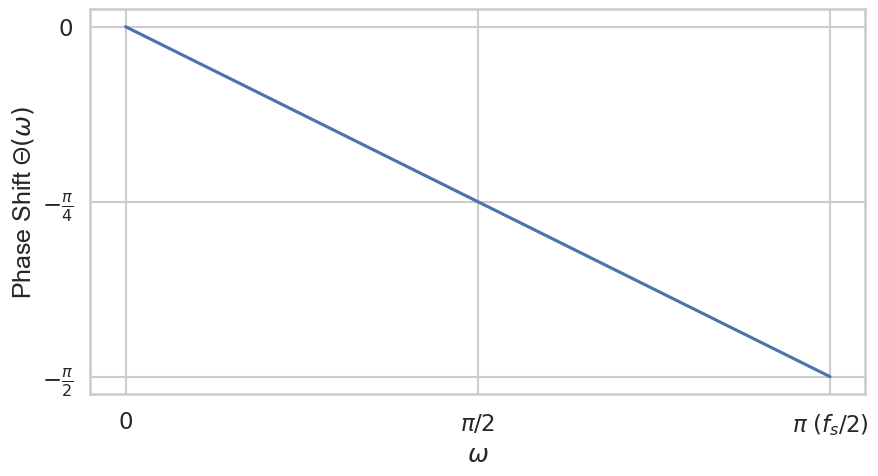

In [3]:
t = np.linspace(0, np.pi, 1000)
phase = lambda x: -x/2

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, phase(t), label=r'$y(t)$')
ax.set_xticks([0, np.pi/2, np.pi])
ax.set_yticks([-np.pi/2, -np.pi/4, 0])
ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$ $(f_s/2)$']);
ax.set_yticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$']);
ax.set_ylabel(r'Phase Shift $\mathcal{\Theta}(\omega)$')
ax.set_xlabel(r'$\omega$');

This *low pass filter* has no phase delay at 0 Hz and a maximum delay of $-(\pi/2)T$ at the Nyquist frequency.
Note that both responses rely on the sample rate $f_s = 1 / T$.
Furthermore, the phase shift depends on $\omega$.
It looks like this might lead to a phase distortion, however, this frequency-dependent delay is counteracted because doubling the frequency of the input halves its period, balancing the growth in retardation introduced by the filter.
This linear dependence is actually necessary.

```{admonition} Linear Phase Filters
:name: def-linear-phase-filter
:class: definition

If the phase response of the filter is a linear (straight-line) function of frequency (excluding phase wraps at $\pm 180$ degree), the filter is said to be *linear phase*.

```

Filters that are not linear phase can introduce *phase distortion*.

```{admonition} General Form of a LTI Filter
:name: def-form-lti-filter
:class: definition

A LTI Filter may be expressed in general as follows:

\begin{equation}
\begin{split}
y[n] &= \text{Transfer function} \cdot \text{Circular motion}\\
&= G(\omega) \cdot e^{i \mathcal{\Theta}(\omega)} \cdot A \cdot e^{i \omega n T + \phi}\\
&= G(\omega) A \cdot e^{i(\omega n T + \Theta(\omega) + \phi)}
\end{split}
\end{equation}

```

Thus, a filter can be characterized as circular motion with radius $G(\omega) A$ and phase $\Theta(\omega)+\phi$.
The particular kind of filter implemented depends only on the definition of $G(\omega)$ and $\Theta(\omega)$.

## General Z-Transformation

The general form for a difference equation is given by 

\begin{equation}
\sum\limits_{k=0}^N a_k y[n-k] = \sum\limits_{k=0}^M b_k x[n-k], \quad a_0 \neq 0
\end{equation}

If we take the Z-transform of both sides we get:

\begin{equation*}
\sum\limits_{k=0}^N a_k z^{-k}Y(z) = \sum\limits_{k=0}^M b_k z^{-k} X(z)
\end{equation*}

and by solving for $Y(z)$ we get

\begin{equation*}
Y(z) = \underbrace{\frac{\sum\limits_{k=0}^M b_k z^{-k}}{\sum\limits_{k=0}^N a_k z^{-k}}}_{H(z)} X(z) = H(z) X(z)
\end{equation*}

where $H(z)$ is the *transfer function*, i.e. the Z-transform of the filter's [frequency response](def-frequency-response), in other words 

$$H(z) = \mathcal{Z}\{h[n]\}.$$

If $b_0 \neq 0$ then

\begin{equation}
H(z) = \frac{b_0}{a_0} \frac{\prod\limits_{k=1}^M (1 - c_k z^{-1})}{\prod\limits_{k=1}^N (1 - d_k z^{-1})}
\end{equation}

where $c_k, k = 1, 2, \ldots M$ are *zeros* and $d_k, k = 1, 2, \ldots N$ are *poles*.

### One Zero Filter

In SuperCollider the *one zero filter* realizes the following formula:

$$y[n] = (1 - |\alpha|) \cdot x[n] + \alpha \cdot x[n-1], \quad -1 \leq \alpha \leq 1$$

we have $N = 0$ and $M = 1, a_0 = 1, b_0 = (1 - |\alpha|), b_1 = \alpha.$
Therefore,

$$\mathcal{F}\{ y[n] \} = \frac{(1 - |\alpha|) + \alpha \cdot z^{-1}}{1} = 1 - |\alpha| + \alpha \cdot z^{-1} = H(z).$$

There is a *pole* at $z = 0$ and a *zero* at $z = \frac{\alpha}{|\alpha|-1}$.
Therefore,

$H(z) = (1 - |\alpha|) \cdot \left(1 - \frac{\alpha}{|\alpha|-1} z^{-1}\right)$

If we evaluate $H(z)$ for $\alpha = 0.5$ at the frequncies of interest we can see the *frequency response*:

$$H(e^{i \omega T}) = 0.5 \cdot (1 - e^{-i\omega T})$$

which is similar result we got in the last section!

Let us plot the *gain* in frequency for $T = 1$ and different $\alpha$:

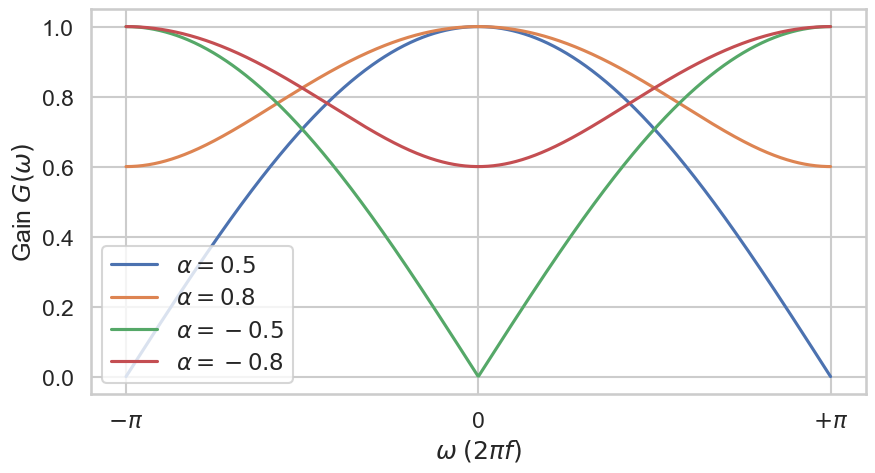

In [4]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x, alpha: (1-np.abs(alpha)) * (1-(alpha/(np.abs(alpha) -1))*np.exp(-1j*x))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, np.abs(gain(t, 0.5)), label=r'$\alpha = 0.5$')
ax.plot(t, np.abs(gain(t, 0.8)), label=r'$\alpha = 0.8$')
ax.plot(t, np.abs(gain(t, -0.5)), label=r'$\alpha = -0.5$')
ax.plot(t, np.abs(gain(t, -0.8)), label=r'$\alpha = -0.8$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'$+\pi$']);
ax.set_ylabel(r'Gain $G(\omega)$')
ax.set_xlabel(r'$\omega$ $(2\pi f)$')
ax.legend();

The unit generator [OneZero](http://doc.sccode.org/Classes/OneZero.html) got his name by the fact that it has **one zero**.

Remember that the filter completely filters $f_s/2$.
But since $f_s = 44100$ the overall effect of the filter hardly audible.
Without a *pole* the filtering effect is weak.

```isc
(
{
    var alpha = 0.9;
    OneZero.ar(WhiteNoise.ar(0.3!2), alpha)
}.play;
)
```

### One Pole Filter

In SuperCollider the *one pole filter* realizes the following formula:

$$y[n] - \alpha \cdot y[n-1] = (1 - |\alpha|) \cdot x[n], \quad -1 \leq \alpha \leq 1$$

we have $N = 1$ and $M = 0, a_0 = 1, a_1 = -\alpha, b_0 = (1 - |\alpha|)$
Therefore,

$$\mathcal{F}\{ y[n] \} = \frac{(1 - |\alpha|)}{1 - \alpha z^{-1}} = H(z).$$

There is a *pole* at $z = \alpha$ and a *zero* at $z = \infty$.
Therefore,

$$H(z) = \frac{(1 - |\alpha|)}{1 - \alpha z^{-1}}.$$

If we evaluate $H(z)$ for $\alpha = 0.5$ at the frequncies of interest we can see the *frequency response*:

$$H(e^{i \omega T}) = \frac{0.5}{1 - 0.5 e^{-i \omega T}} = \frac{1}{2 - e^{-i \omega T}}.$$

Let us plot the *gain* in frequency for $T = 1$ and different $\alpha$:

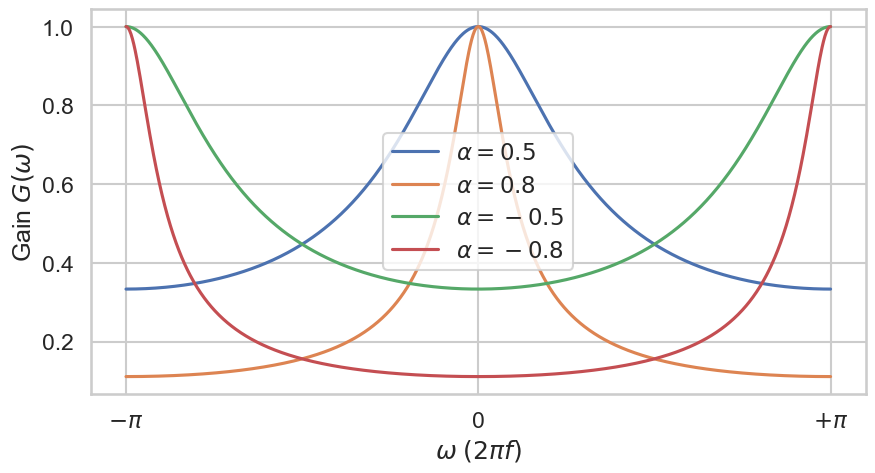

In [5]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x, alpha: (1-np.abs(alpha)) / (1-alpha*np.exp(-1j*x))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, np.abs(gain(t, 0.5)), label=r'$\alpha = 0.5$')
ax.plot(t, np.abs(gain(t, 0.8)), label=r'$\alpha = 0.8$')
ax.plot(t, np.abs(gain(t, -0.5)), label=r'$\alpha = -0.5$')
ax.plot(t, np.abs(gain(t, -0.8)), label=r'$\alpha = -0.8$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'$+\pi$']);
ax.set_ylabel(r'Gain $G(\omega)$')
ax.set_xlabel(r'$\omega$ $(2\pi f)$')
ax.legend();

The unit generator [OnePole](http://doc.sccode.org/Classes/OneZero.html) got his name by the fact that it has **one pole**.
Compared to the *one zero filter* it is able to have a much steeper drop / increase in *gain*.
Similar to the *one zero filter* it is a low pass filter for positive $\alpha$ and high pass filter for negative $\alpha$.
For both these filters, the cutoff frequency $f_c$ is equal to 0 Hz, i.e., all frequencies are effected.

```isc
(
{
    var alpha = 0.9;
    OnePole.ar(WhiteNoise.ar(0.3!2), 0.95)
}.play;
)
```

## Impulse Response

The fundamental result in [LTI](def-linear-time-invariant) system theory is that any LTI system can be characterized entirely by a single function called the system's *impulse response* (in the time domain).
The output of the filter $y[n]$ is simply the convolution of the input to the filter $x[n]$ with the system's *impulse response* $h[n]$.

```{admonition} Impulse Response
:name: def-impulse-response
:class: definition

The *impulse response*, or *impulse response function (IRF)*, of a filter is its output when presented with a brief input signal, called an *impulse* $\delta(t)$.
(In the discrete case we write $\delta[n]$ instead.)

```

The *Dirac delta distribution* ($\delta$ distribution), also known as *unit impulse*, is a generalized function or distribution over the real numbers, whose value is zero everywhere expect at zero, and whose integral over the entire real line is equal to one:

$$\delta(t) = 0 \Rightarrow t \neq 0 \qquad \int_{-\infty}^\infty \delta(t) dt = 1.$$

Strictly speaking $\delta(t)$ not a function because it is not defined for $\delta(0)$.
One can define

$$\delta(t) = \lim\limits_{b \rightarrow 0} \frac{1}{|b| \sqrt{\pi}} e^{-(x/b)^2}.$$

Interestingly, the Dirac delta function is the neutral element of the [convolution](sec-convolution), that is,

$$(y * \delta) = (\delta * y) = y.$$

In the discrete case, things are more intuitive via the *Kronecker delta function* $\delta[n]$.

```{admonition} Kronecker $\delta$-Function
:name: def-kronecker-delta
:class: definition

The *Kronecker delta function* $\delta : \mathbb{Z} \rightarrow \{0, 1\}$ is defined by 

\begin{equation}
\delta[n] = \begin{cases}
1, & \text{if } n = 0,\\
0, & \text{otherwise}.
\end{cases}
\end{equation}

```

It is the discrete analog of the *Dirac delta function*.
For example, the filter response of our *simple filter* is

$$y[n] = \delta[n] + \delta[n-1], n = 0, 1, 2, \ldots$$

which gives us $y[0] = y[1] = 1$ and $y[n] = 0$ for all $n \geq 2$.
Note that any signal $x[\cdot]$ can be expressed as a combination of weighted delta functions, i.e.,

$$x[n] = \delta_n[n] \cdot x[n] \text{ with } \delta_n[k] = \delta[k-n].$$

TODO